# **Jigsaw Unintended Bias: First Cut**

# **Contents**
### 1. Define functions to compute custom metric
### 2. Define a class to handle hyper-parameter tuning, model training, visualize performance   
### 3. Try out simple models on distinctly vectorized text data 
### 4. Summary
### 5. References

In [ ]:
#import dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import log10

from scipy.sparse import load_npz

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

from tqdm import tqdm 
import sys
import os
import warnings 
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

## **1. Define functions to compute custom metric**

In [ ]:
#eval metric explanation - https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation
#code snippet - https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]==1]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name]) #(y_true, y_pred)

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]==1) & (df[label]==0)]
    non_subgroup_positive_examples = df[(df[subgroup]==0) & (df[label]==1)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]==1) & (df[label]==1)]
    non_subgroup_negative_examples = df[(df[subgroup]==0) & (df[label]==0)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col, include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]==1])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
    
def calculate_overall_auc(df, model_name):
    '''Calculates the AUC for all data.'''
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25, Wa = 0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    # 3/4*(a+b+c/3) == 1/4(a+b+c)
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

## **2. Define a class to handle hyper-parameter tuning, model training, visualize performance**

In [ ]:
'''Helper Functions - to find and predict with best threshold'''

#Best threshold is the one where TPR is high and FPR is low
#so we need to maximize TPR and minimize FPR or in other words maximize (1-FPR), therefore we use TPR*(1-FPR) as a metric to find the best threshold
def find_best_threshold(threshold, fpr, tpr):
    #np.argmax returns the index of the highest valued element in the list 
    thresh = threshold[np.argmax(tpr*(1-fpr))] 
    print("The maximum value of TPR*(1-FPR)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
    return thresh

#below function uses the best threshold value as a condition to obtain predicted target classes (i.e. y_pred) from model predicted probabilities
#obtaining y_pred is essential for our next step which is evaluating the model performance
def predict_with_best_t(y_prob, thresh):
    y_pred = np.array([0 if x<thresh else 1 for x in y_prob])
    return y_pred

In [ ]:
class BuildModel:
    def __init__(self, TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE):
        self.MODEL_NAME = MODEL_NAME
        self.TOXICITY_COLUMN = TOXICITY_COLUMN
        self.IDENTITY_COLUMNS = IDENTITY_COLUMNS
        self.PARAM_RANGE = PARAM_RANGE
    
    def model_tuning(self, train, cv, X_train_vec, y_train, X_cv_vec, y_cv, plot_results=False):
        '''Conducts Hyperparameter Tuning and returns the results in a dataframe.'''
        custom_scores_tr = []
        custom_scores_cv = []

        for param in tqdm(self.PARAM_RANGE):
            
            if 'logreg' in self.MODEL_NAME:
                model = LogisticRegression(C = param, solver = 'lbfgs', class_weight='balanced', max_iter = 100, n_jobs=-1, random_state=42)
            
            elif 'svm' in self.MODEL_NAME:
                model = SGDClassifier(loss = 'hinge', alpha = param, class_weight='balanced', n_jobs=-1, random_state=42)
                #model = LinearSVC(C = param, class_weight='balanced', random_state=42)
            
            elif 'multinb' in self.MODEL_NAME:
                model = MultinomialNB(alpha = param, fit_prior = True)
            
            else:
                model = RandomForestClassifier(max_depth = param, n_jobs = -1, random_state=42)
            
            model_cc = CalibratedClassifierCV(model, cv = 3, method="sigmoid")
            model_cc.fit(X_train_vec, y_train)

            train[self.MODEL_NAME] = model_cc.predict_proba(X_train_vec)[:,1]
            bias_metrics_train = compute_bias_metrics_for_model(train, self.IDENTITY_COLUMNS, self.MODEL_NAME, self.TOXICITY_COLUMN)
            custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(train, self.MODEL_NAME))
            custom_scores_tr.append(custom_train)

            cv[self.MODEL_NAME] = model_cc.predict_proba(X_cv_vec)[:,1]
            bias_metrics_cv = compute_bias_metrics_for_model(cv, self.IDENTITY_COLUMNS, self.MODEL_NAME, self.TOXICITY_COLUMN)
            custom_cv = get_final_metric(bias_metrics_cv, calculate_overall_auc(cv, self.MODEL_NAME))
            custom_scores_cv.append(custom_cv)
        
        results = pd.DataFrame({'Hyperparam_Values':self.PARAM_RANGE, 'Custom_AUC_Train':custom_scores_tr, 'Custom_AUC_CV':custom_scores_cv})
        
        #if True, returns Custom Metric vs Log(param) plot
        if plot_results:
            if 'logreg' in self.MODEL_NAME or 'svm' in self.MODEL_NAME or 'multinb' in self.MODEL_NAME:
                param_val = results['Hyperparam_Values'].apply(lambda x: log10(x))
            else:
                param_val = results['Hyperparam_Values']
            
            plt.figure(figsize=(8,6))
            plt.plot(param_val, custom_scores_tr, label='Train Custom AUC')
            plt.scatter(param_val, custom_scores_tr, label='Train Custom AUC points')

            plt.plot(param_val, custom_scores_cv, label='CV Custom AUC')
            plt.scatter(param_val, custom_scores_cv, label='CV Custom AUC points')
            
            if 'logreg' in self.MODEL_NAME or 'svm' in self.MODEL_NAME:
                plt.xlabel("Hyperparameter : Log(C)")
                plt.title("Custom AUC vs Log(C) values (to choose the best C)")

            elif 'multinb' in self.MODEL_NAME:
                plt.xlabel("Hyperparameter : Log(Alpha)")
                plt.title("Custom AUC vs Log(Alpha) values (to choose the best Alpha)")
            
            else:
                plt.xlabel("Hyperparameter : Max Depth")
                plt.title("Custom AUC vs Max Depth values (to choose the best Max Depth)")

            plt.ylabel("Custom AUC")
            plt.grid()
            plt.legend()
            plt.show()
        
        self.results = results.sort_values(['Custom_AUC_CV'], ascending=False)
        return self.results
    
    def optimised_model_instance(self, train, test, X_train_vec, y_train, X_test_vec, y_test, roc_and_confusion=False):
        '''Conducts model training using the best hyperparameters and returns the optimised model.'''
        best_param = self.results.iloc[0,0]
        
        if 'logreg' in self.MODEL_NAME:
            best_model = LogisticRegression(C = best_param, solver = 'lbfgs', class_weight='balanced', max_iter = 100, n_jobs=-1, random_state=42)
        
        elif 'svm' in self.MODEL_NAME:
            best_model = SGDClassifier(loss = 'hinge', alpha = best_param, class_weight='balanced', n_jobs=-1, random_state=42)
            #best_model = LinearSVC(C = best_param, class_weight='balanced', random_state=42)
        
        elif 'multinb' in self.MODEL_NAME:
            best_model = MultinomialNB(alpha = best_param, fit_prior = True)
        
        else:
            best_model = RandomForestClassifier(max_depth = best_param, n_jobs=-1, random_state=42)
            
        best_model_cc = CalibratedClassifierCV(best_model, cv = 3, method="sigmoid")
        best_model_cc.fit(X_train_vec, y_train)
        
        train[self.MODEL_NAME] = best_model_cc.predict_proba(X_train_vec)[:,1]
        bias_metrics_train = compute_bias_metrics_for_model(train, self.IDENTITY_COLUMNS, self.MODEL_NAME, self.TOXICITY_COLUMN)
        custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(train, self.MODEL_NAME))
        auc_train = roc_auc_score(y_train, train[self.MODEL_NAME].values)
        
        test[self.MODEL_NAME] = best_model_cc.predict_proba(X_test_vec)[:,1]
        bias_metrics_test = compute_bias_metrics_for_model(test, self.IDENTITY_COLUMNS, self.MODEL_NAME, self.TOXICITY_COLUMN)
        custom_test = get_final_metric(bias_metrics_test, calculate_overall_auc(test, self.MODEL_NAME))
        auc_test = roc_auc_score(y_test, test[self.MODEL_NAME].values)

        print(f'Train Custom AUC Metric: {custom_train}')
        print(f'Test Custom AUC Metric: {custom_test}')
        print('\n')
        print(f'Train Overall AUC Metric: {auc_train}')
        print(f'Test Overall AUC Metric: {auc_test}')

        train_fpr, train_tpr, tr_thresh = roc_curve(y_train, train[self.MODEL_NAME])
        test_fpr, test_tpr, te_thresh = roc_curve(y_test, test[self.MODEL_NAME])
        
        #if True, the method also return a roc curve plot and confusion matrix 
        if roc_and_confusion:
            best_thresh = find_best_threshold(tr_thresh, train_fpr, train_tpr)

            y_train_pred = predict_with_best_t(train[self.MODEL_NAME].values, best_thresh)
            y_test_pred = predict_with_best_t(test[self.MODEL_NAME].values, best_thresh)

            confusion_train = confusion_matrix(y_train, y_train_pred)
            confusion_test = confusion_matrix(y_test, y_test_pred)

            fig, ax = plt.subplots(nrows=3,ncols=1, figsize = (8,24))

            ax[0].plot(train_fpr, train_tpr, label='Train AUC = '+str(auc(train_fpr, train_tpr)))
            ax[0].plot(test_fpr, test_tpr, label='Test AUC = '+str(auc(test_fpr, test_tpr)))

            ax[0].set(xlabel = "False Positive Rate (FPR)", ylabel ="True Positive Rate (TPR)", title = "ROC Curve")
            ax[0].legend()
            ax[0].grid()

            cm_train_df = pd.DataFrame(confusion_train,
                 index = [0, 1], 
                 columns = [0, 1])
            sns.heatmap(cm_train_df, annot=True, fmt='g', ax=ax[1])
            ax[1].set(title = 'Confusion Matrix of Train', ylabel='Actual Values', xlabel='Predicted Values')

            cm_test_df = pd.DataFrame(confusion_test,
                 index = [0, 1], 
                 columns = [0, 1])
            sns.heatmap(cm_test_df, annot=True, fmt='g', ax=ax[2])
            ax[2].set(title = 'Confusion Matrix of Test', ylabel='Actual Values', xlabel='Predicted Values')

            plt.show()
        
        return best_model_cc

## **3. Try out simple models on distinctly vectorized text data**

**We have vectorized text data in the following ways:**
- Bag of Words (BOW)
- TF-IDF
- Average Word2Vec (Pretrained Word Embedding)
- Average Glove (Pretrained Word Embedding)

**We aim to try out the below models on the above mentioned vectorizations of text data:**
- Naive Bayes
- Logistic Regression
- Support Vector Machines
- Random Forest

In [ ]:
train = pd.read_pickle('X_train.pkl')
cv = pd.read_pickle('X_cv.pkl')
test = pd.read_pickle('X_test.pkl')

y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [ ]:
train['target'] = y_train
cv['target'] = y_cv
test['target'] = y_test

In [ ]:
TOXICITY_COLUMN = 'target'
IDENTITY_COLUMNS = ['male', 'female', 'black', 'white', 'jewish', 'muslim','christian', 'homosexual_gay_or_lesbian', 'psychiatric_or_mental_illness']

## **3.1 Naive Bayes**

**Note:** MultinomialNB doesn't work with negative values and W2V and GloVe vectorized data consists of negative values so we only train MultinomialNB on BOW and TFIDF vectorized data.

### **3.1.1 Naive Bayes on BOW**

In [ ]:
X_train_bow = load_npz('X_train_bow.npz')
X_cv_bow = load_npz('X_cv_bow.npz')
X_test_bow = load_npz('X_test_bow.npz')

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [01:58<00:00,  8.46s/it]


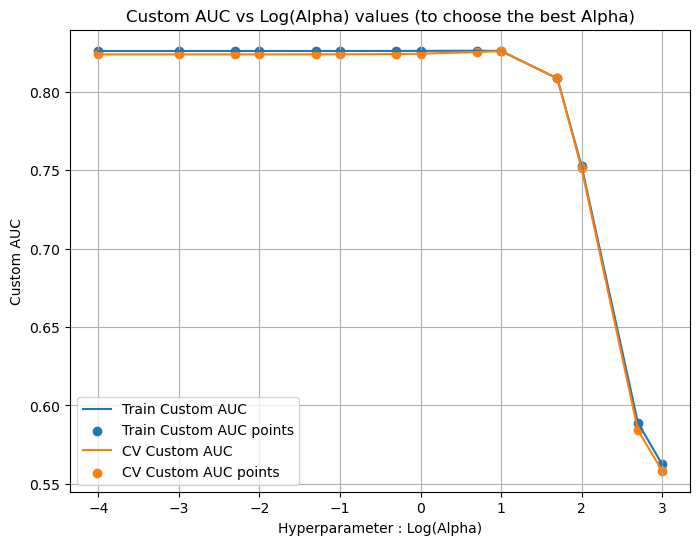

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
9,10.0000,0.826078,0.825922
8,5.0000,0.826196,0.825378
7,1.0000,0.826089,0.824293
6,0.5000,0.826056,0.824090
5,0.1000,0.826027,0.823913
4,0.0500,0.826022,0.823887
3,0.0100,0.826019,0.823867
2,0.0050,0.826019,0.823864
1,0.0010,0.826018,0.823862
0,0.0001,0.826018,0.823861


In [ ]:
MODEL_NAME = 'multinb_bow'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

multinb_bow = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
multinb_bow.model_tuning(train, cv, X_train_bow, y_train, X_cv_bow, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8260779085539295
Test Custom AUC Metric: 0.8254592042206685


Train Overall AUC Metric: 0.8557862299831265
Test Overall AUC Metric: 0.8513703908743671
The maximum value of TPR*(1-FPR) 0.6375920363938921 for threshold 0.05


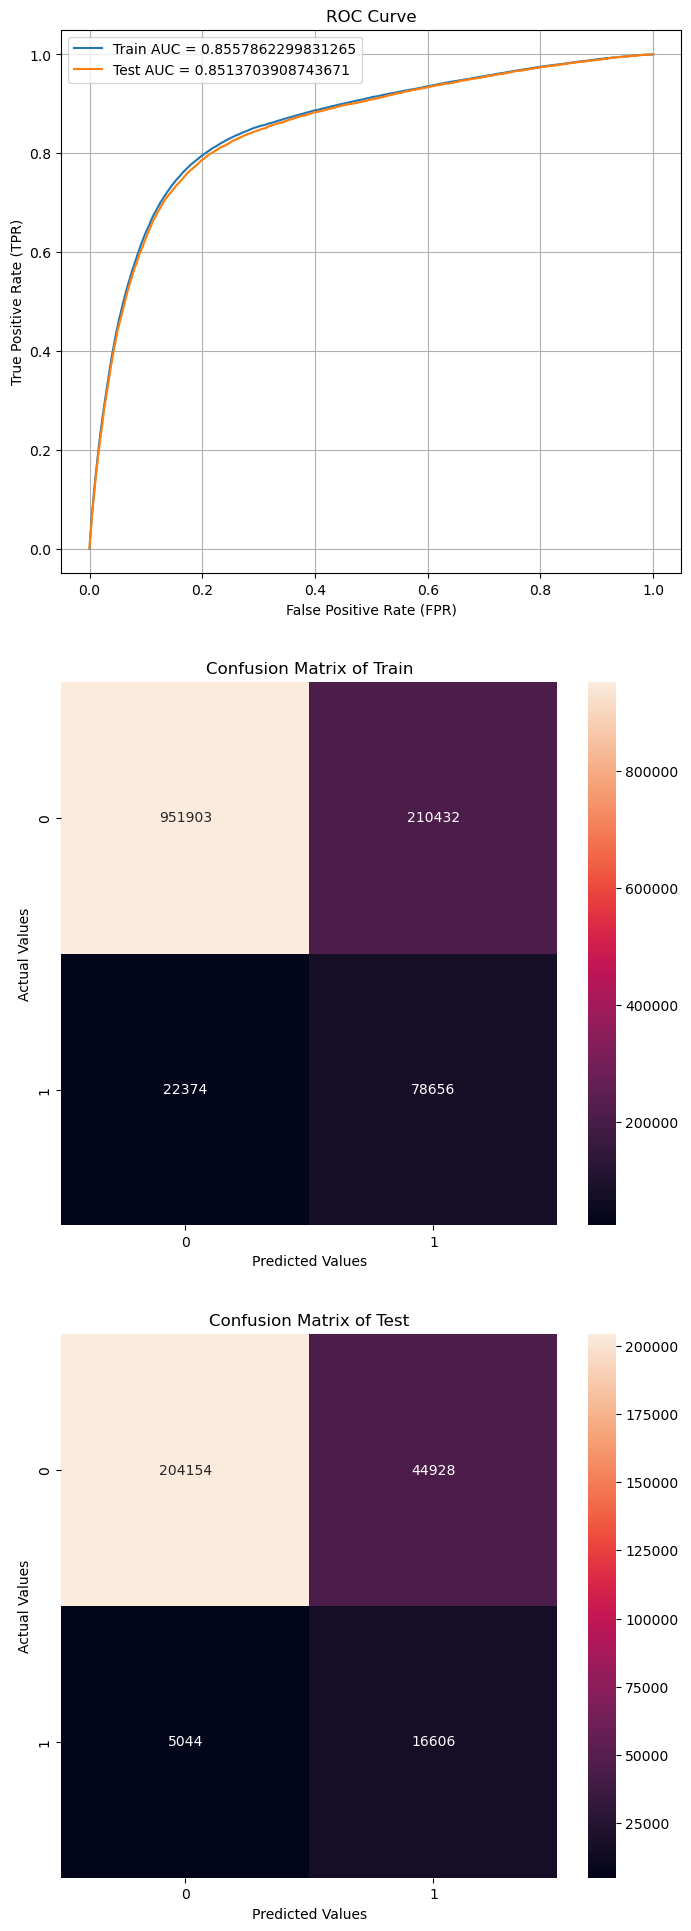

In [ ]:
opt_multinb_bow = multinb_bow.optimised_model_instance(train, test, X_train_bow, y_train, X_test_bow, y_test, roc_and_confusion=True)

### **3.1.2 Naive Bayes on TF-IDF**

In [ ]:
X_train_tfidf = load_npz('X_train_tfidf.npz')
X_cv_tfidf = load_npz('X_cv_tfidf.npz')
X_test_tfidf = load_npz('X_test_tfidf.npz')

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [01:53<00:00,  8.12s/it]


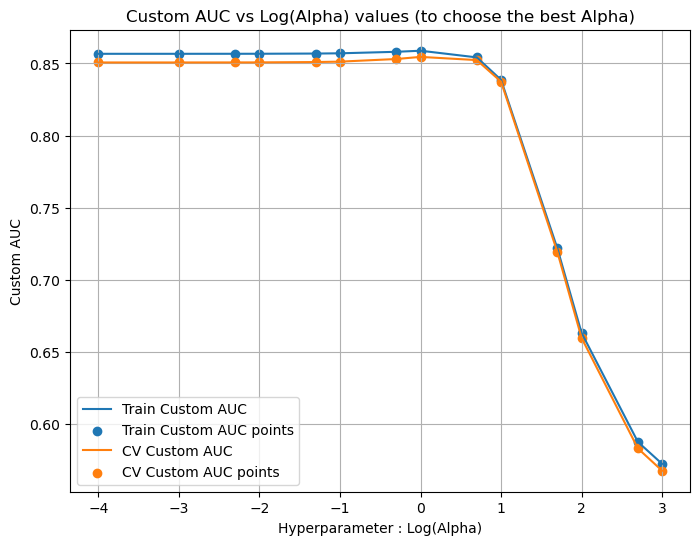

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
7,1.0000,0.858836,0.854552
6,0.5000,0.858093,0.853085
8,5.0000,0.854207,0.852343
5,0.1000,0.857041,0.851265
4,0.0500,0.856873,0.850987
3,0.0100,0.856732,0.850749
2,0.0050,0.856714,0.850721
1,0.0010,0.856700,0.850697
0,0.0001,0.856698,0.850691
9,10.0000,0.838630,0.837372


In [ ]:
MODEL_NAME = 'multinb_tfidf'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

multinb_tfidf = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
multinb_tfidf.model_tuning(train, cv, X_train_tfidf, y_train, X_cv_tfidf, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8588358883756066
Test Custom AUC Metric: 0.8542358423763388


Train Overall AUC Metric: 0.8808873611885037
Test Overall AUC Metric: 0.874003901309442
The maximum value of TPR*(1-FPR) 0.6492371795565576 for threshold 0.064


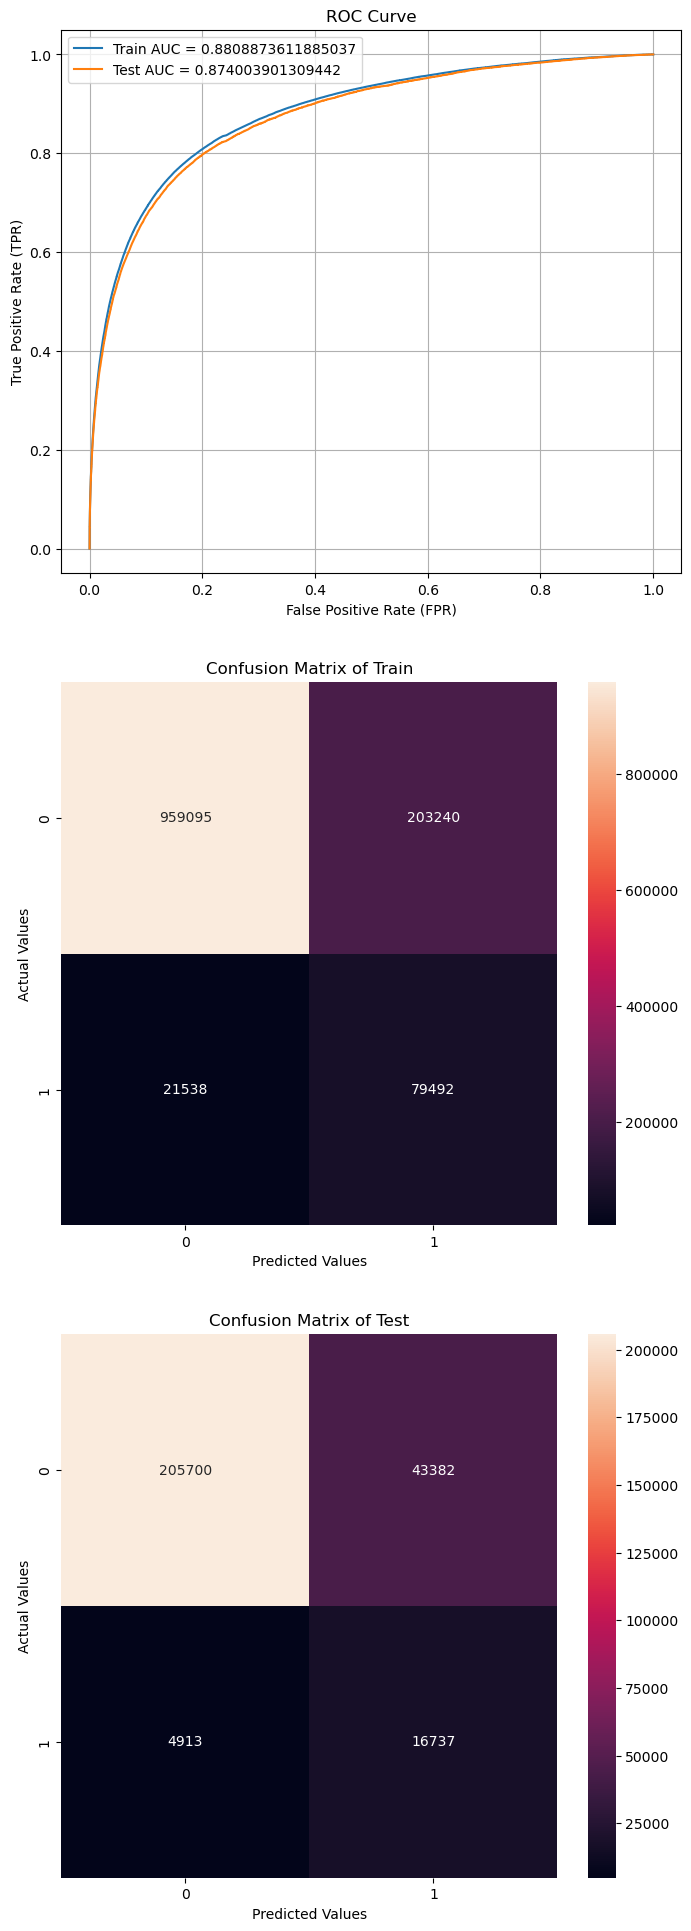

In [ ]:
opt_multinb_tfidf = multinb_tfidf.optimised_model_instance(train, test, X_train_tfidf, y_train, X_test_tfidf, y_test, roc_and_confusion=True)

## **3.2 Logistic Regression**

### **3.2.1 Logistic Regression on BOW**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [13:19<00:00, 57.14s/it]


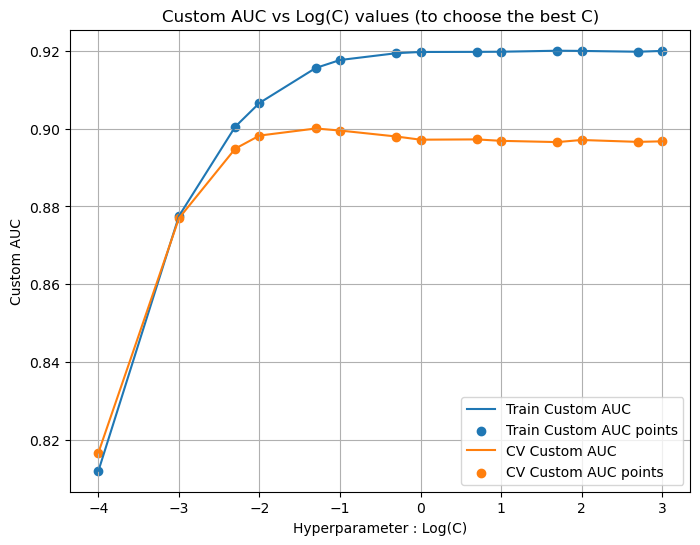

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
4,0.0500,0.915573,0.900027
5,0.1000,0.917615,0.899501
3,0.0100,0.906593,0.898208
6,0.5000,0.919367,0.897968
8,5.0000,0.919705,0.897224
7,1.0000,0.919680,0.897151
11,100.0000,0.919954,0.897073
9,10.0000,0.919744,0.896855
13,1000.0000,0.919951,0.896729
12,500.0000,0.919745,0.896587


In [ ]:
MODEL_NAME = 'logreg_bow'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

logreg_bow = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
logreg_bow.model_tuning(train, cv, X_train_bow, y_train, X_cv_bow, y_cv, plot_results=True)

Train Custom AUC Metric: 0.9155729912579502
Test Custom AUC Metric: 0.89739944897241


Train Overall AUC Metric: 0.9426077966266966
Test Overall AUC Metric: 0.925762999609856
The maximum value of TPR*(1-FPR) 0.7744082906960287 for threshold 0.071


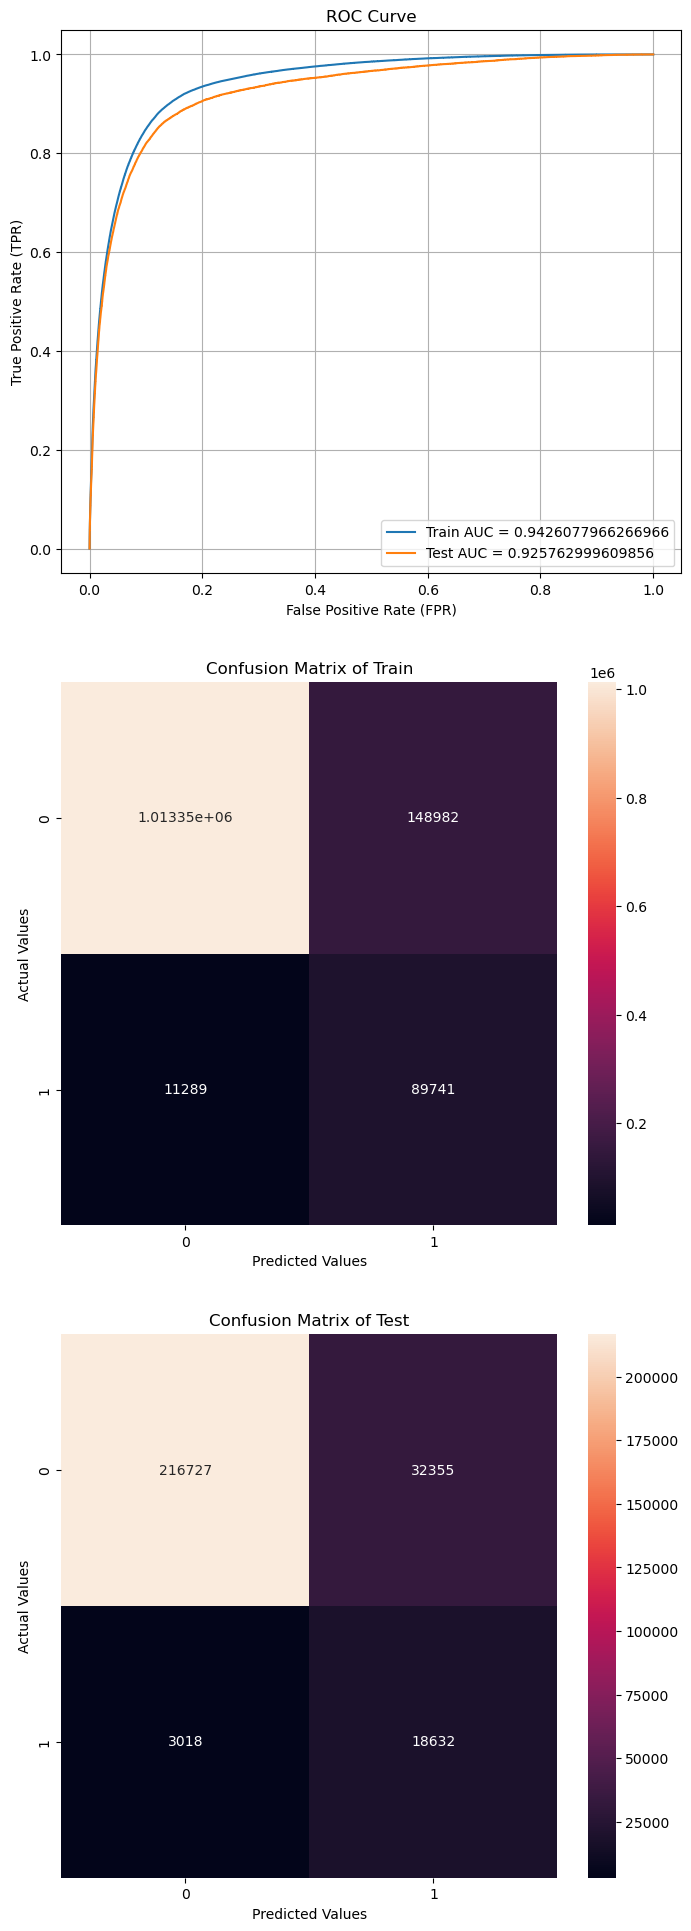

In [ ]:
opt_logreg_bow = logreg_bow.optimised_model_instance(train, test, X_train_bow, y_train, X_test_bow, y_test, roc_and_confusion=True)

### **3.2.2 Logistic Regression on TF-IDF**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [12:33<00:00, 53.80s/it]


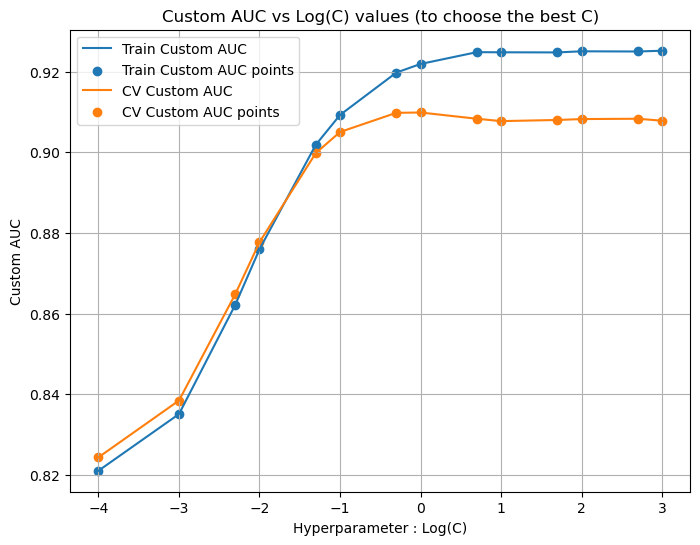

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
7,1.0000,0.921881,0.909855
6,0.5000,0.919738,0.909771
8,5.0000,0.924806,0.908305
12,500.0000,0.924971,0.908305
11,100.0000,0.925018,0.908225
10,50.0000,0.924744,0.908000
13,1000.0000,0.925163,0.907818
9,10.0000,0.924773,0.907718
5,0.1000,0.909241,0.905017
4,0.0500,0.901852,0.899791


In [ ]:
MODEL_NAME = 'logreg_tfidf'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

logreg_tfidf = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
logreg_tfidf.model_tuning(train, cv, X_train_tfidf, y_train, X_cv_tfidf, y_cv, plot_results=True)

Train Custom AUC Metric: 0.9218808561121954
Test Custom AUC Metric: 0.9058852067124205


Train Overall AUC Metric: 0.9483918490617971
Test Overall AUC Metric: 0.9348179834597445
The maximum value of TPR*(1-FPR) 0.7749804196887942 for threshold 0.067


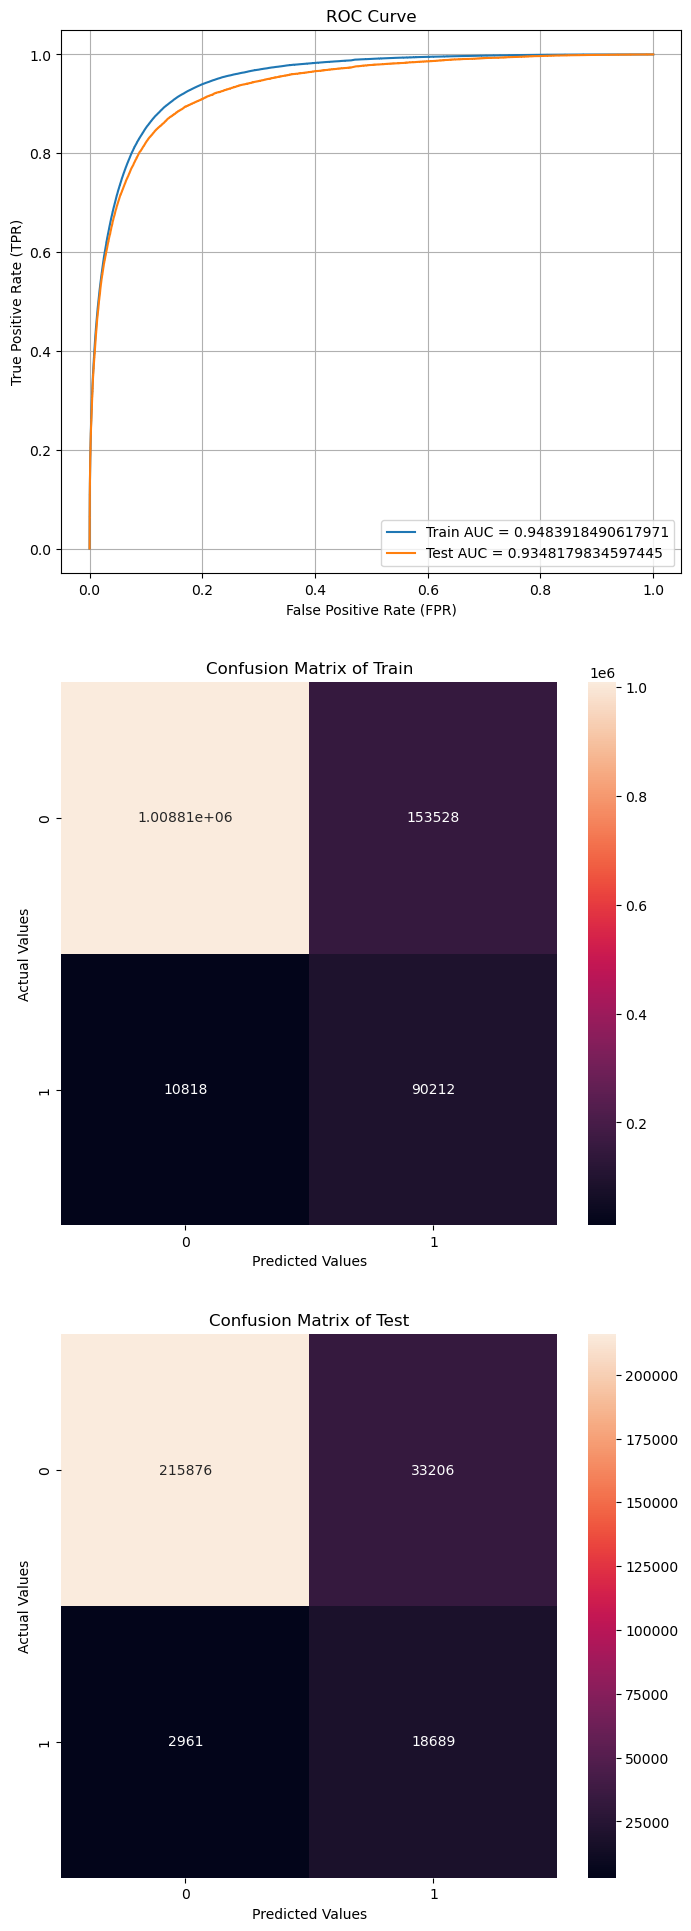

In [ ]:
opt_logreg_tfidf = logreg_tfidf.optimised_model_instance(train, test, X_train_tfidf, y_train, X_test_tfidf, y_test, roc_and_confusion=True)

### **3.2.3 Logistic Regression on W2V**

In [ ]:
X_train_w2v = np.load('X_train_w2v.npy')
X_cv_w2v = np.load('X_cv_w2v.npy')
X_test_w2v = np.load('X_test_w2v.npy')

100%|█████████████████████████████████████████████████████████████████████████| 14/14 [30:33<00:00, 130.93s/it]


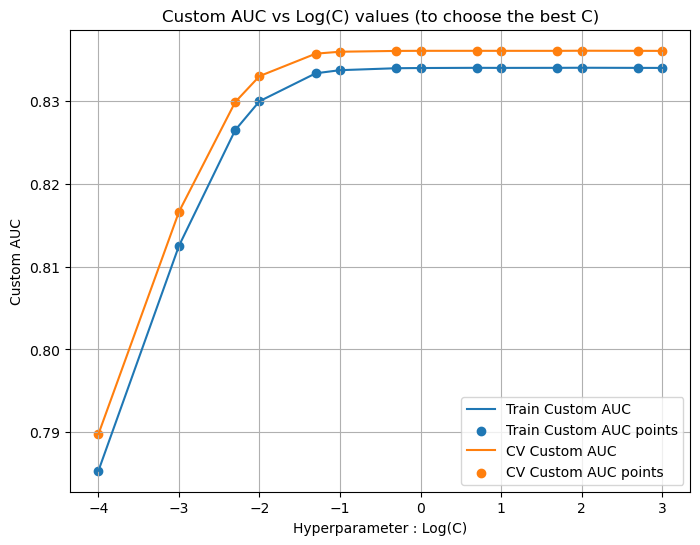

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
11,100.0000,0.834023,0.836079
7,1.0000,0.833989,0.836068
8,5.0000,0.834014,0.836067
9,10.0000,0.834005,0.836066
12,500.0000,0.834007,0.836066
10,50.0000,0.834012,0.836064
13,1000.0000,0.834001,0.836060
6,0.5000,0.833966,0.836055
5,0.1000,0.833729,0.835957
4,0.0500,0.833354,0.835725


In [ ]:
MODEL_NAME = 'logreg_w2v'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

logreg_w2v = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
logreg_w2v.model_tuning(train, cv, X_train_w2v, y_train, X_cv_w2v, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8340226406399707
Test Custom AUC Metric: 0.8319392716682252


Train Overall AUC Metric: 0.865049537603879
Test Overall AUC Metric: 0.8641907449048982
The maximum value of TPR*(1-FPR) 0.619421267478799 for threshold 0.073


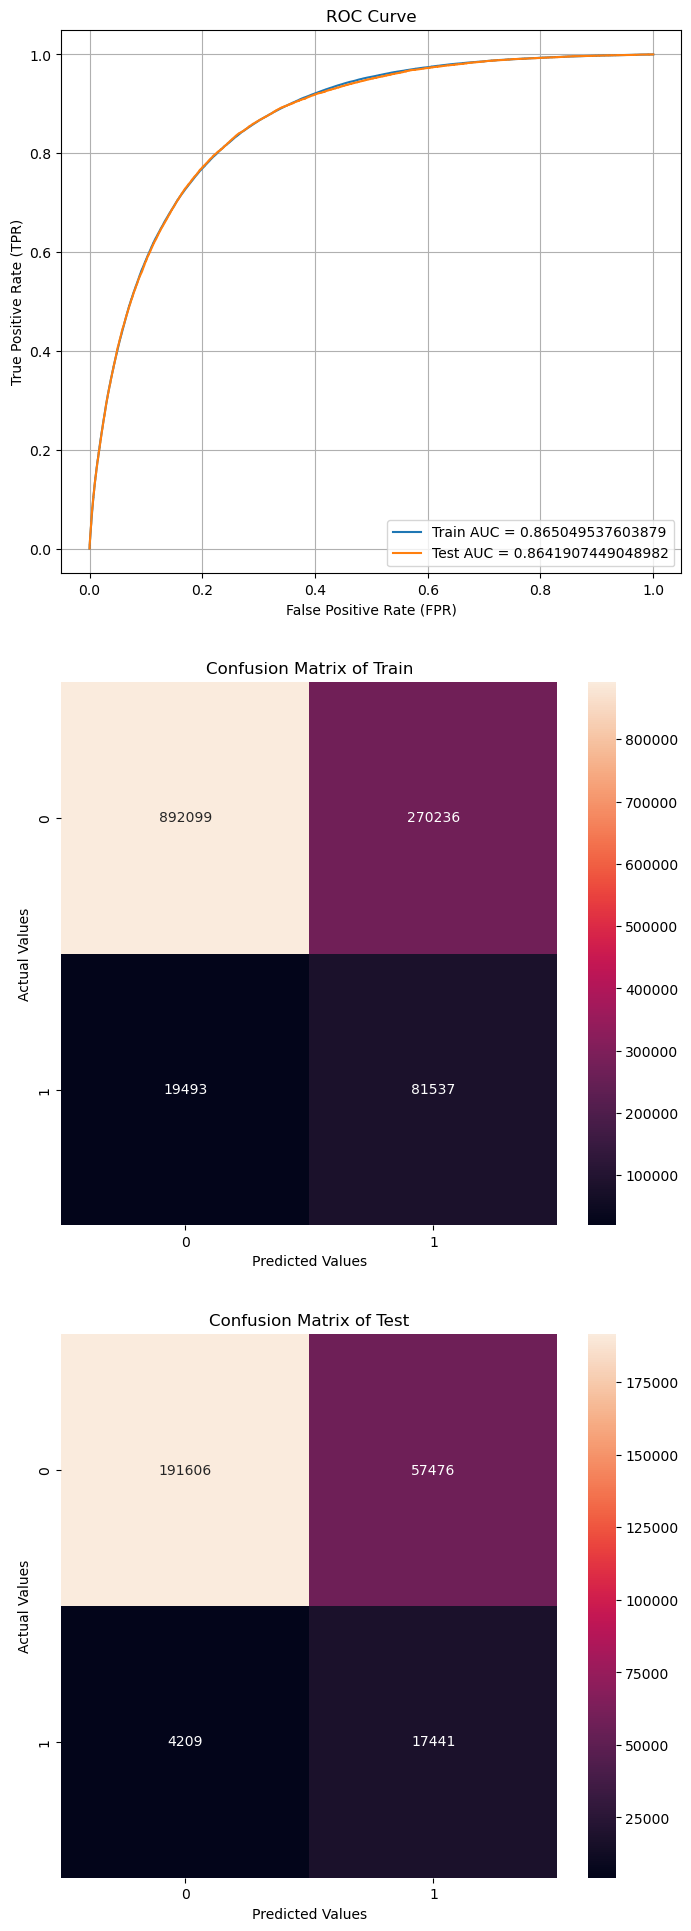

In [ ]:
opt_logreg_w2v = logreg_w2v.optimised_model_instance(train, test, X_train_w2v, y_train, X_test_w2v, y_test, roc_and_confusion=True)

### **3.2.4 Logistic Regression on Glove**

In [ ]:
X_train_glove = np.load('X_train_glove.npy')
X_cv_glove = np.load('X_cv_glove.npy')
X_test_glove = np.load('X_test_glove.npy')

100%|█████████████████████████████████████████████████████████████████████████| 14/14 [34:31<00:00, 147.98s/it]


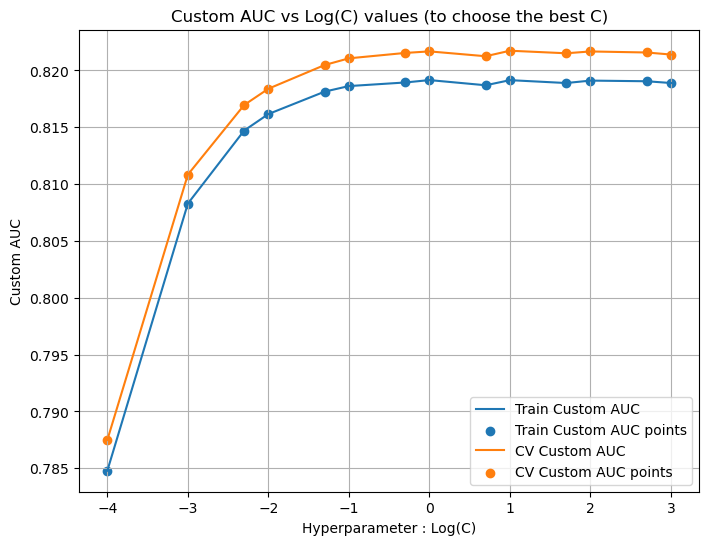

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
9,10.0000,0.819143,0.821732
7,1.0000,0.819149,0.821673
11,100.0000,0.819104,0.821668
12,500.0000,0.819046,0.821576
6,0.5000,0.818938,0.821537
10,50.0000,0.818890,0.821507
13,1000.0000,0.818891,0.821396
8,5.0000,0.818694,0.821247
5,0.1000,0.818622,0.821063
4,0.0500,0.818133,0.820474


In [ ]:
MODEL_NAME = 'logreg_glove'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

logreg_glove = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
logreg_glove.model_tuning(train, cv, X_train_glove, y_train, X_cv_glove, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8191428380307221
Test Custom AUC Metric: 0.8161254327526302


Train Overall AUC Metric: 0.8555230106872291
Test Overall AUC Metric: 0.8553362900070213
The maximum value of TPR*(1-FPR) 0.6036624733353758 for threshold 0.073


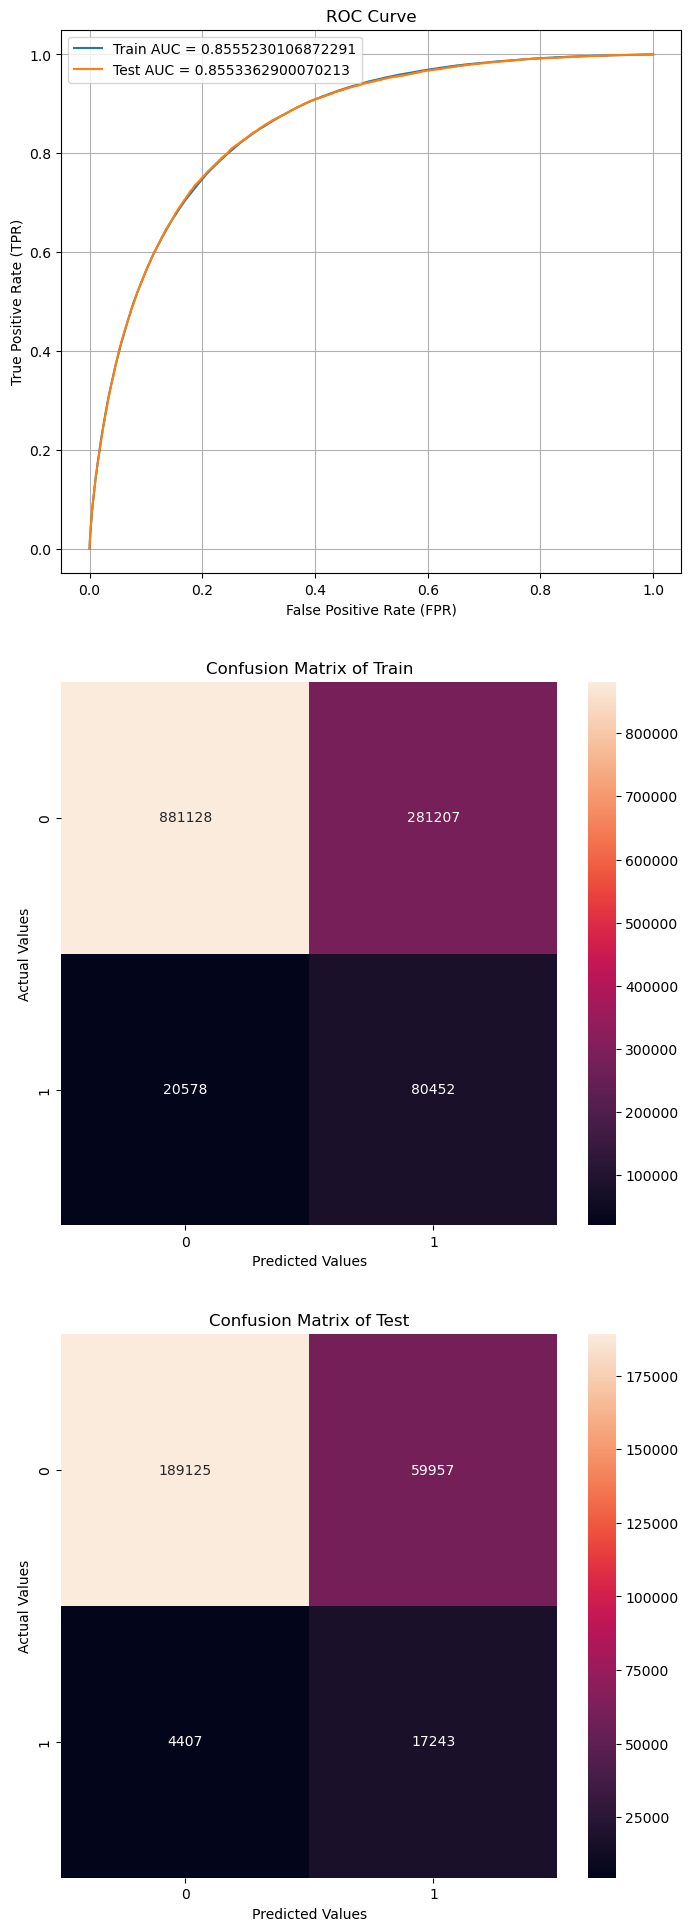

In [ ]:
opt_logreg_glove = logreg_glove.optimised_model_instance(train, test, X_train_glove, y_train, X_test_glove, y_test, roc_and_confusion=True)

## **3.3 SVM**

### **3.3.1 SVM on BOW**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [05:08<00:00, 22.01s/it]


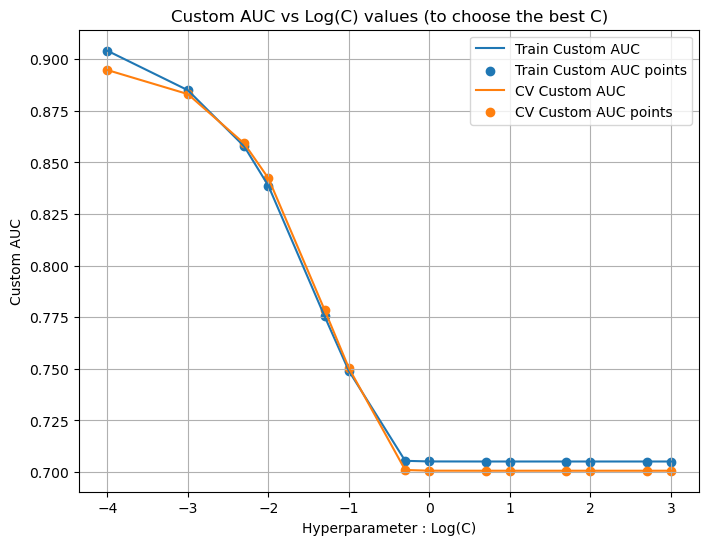

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
0,0.0001,0.904137,0.894781
1,0.0010,0.884999,0.883120
2,0.0050,0.857839,0.859214
3,0.0100,0.838714,0.842385
4,0.0500,0.775386,0.778475
5,0.1000,0.748973,0.750355
6,0.5000,0.705431,0.700980
7,1.0000,0.705136,0.700664
9,10.0000,0.705103,0.700636
10,50.0000,0.705103,0.700636


In [ ]:
MODEL_NAME = 'svm_bow'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

svm_bow = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
svm_bow.model_tuning(train, cv, X_train_bow, y_train, X_cv_bow, y_cv, plot_results=True)

Train Custom AUC Metric: 0.9041374074550483
Test Custom AUC Metric: 0.8915887247146883


Train Overall AUC Metric: 0.9369155858057245
Test Overall AUC Metric: 0.9266061386649652
The maximum value of TPR*(1-FPR) 0.7635038190380004 for threshold 0.063


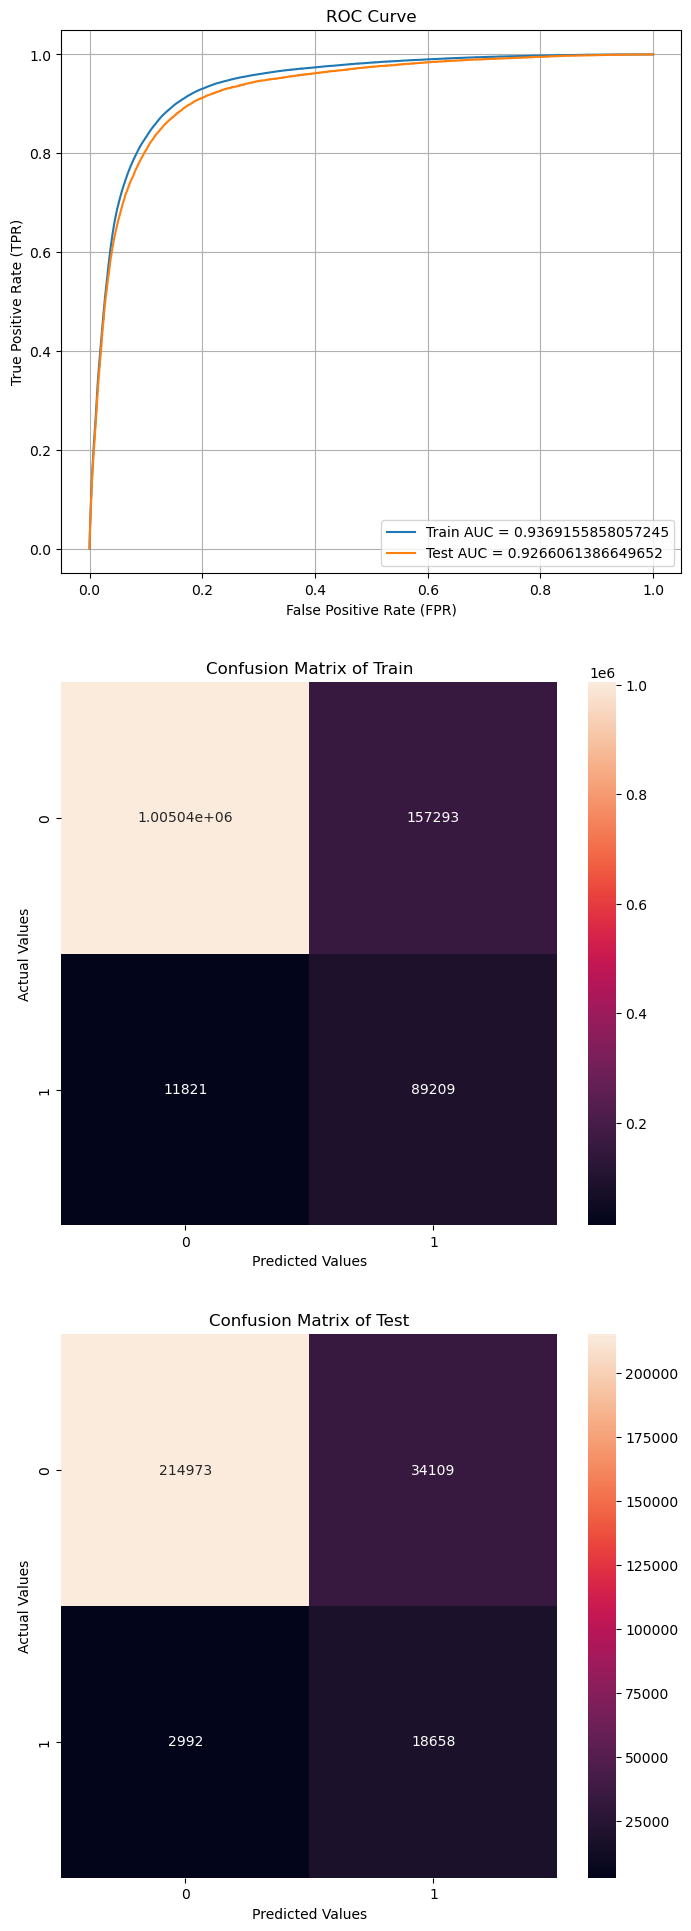

In [ ]:
opt_svm_bow = svm_bow.optimised_model_instance(train, test, X_train_bow, y_train, X_test_bow, y_test, roc_and_confusion=True)

### **3.3.2 SVM on TF-IDF**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [03:56<00:00, 16.91s/it]


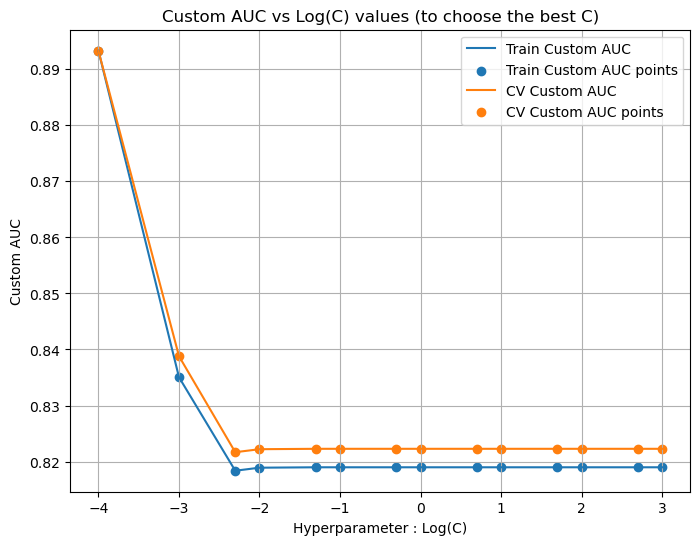

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
0,0.0001,0.893316,0.893285
1,0.0010,0.835052,0.838805
4,0.0500,0.818979,0.822276
5,0.1000,0.818979,0.822276
6,0.5000,0.818979,0.822276
7,1.0000,0.818979,0.822276
8,5.0000,0.818979,0.822276
9,10.0000,0.818979,0.822276
10,50.0000,0.818979,0.822276
11,100.0000,0.818979,0.822276


In [ ]:
MODEL_NAME = 'svm_tfidf'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

svm_tfidf = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
svm_tfidf.model_tuning(train, cv, X_train_tfidf, y_train, X_cv_tfidf, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8933155431996024
Test Custom AUC Metric: 0.888959993569775


Train Overall AUC Metric: 0.9314064502118903
Test Overall AUC Metric: 0.9280159153650078
The maximum value of TPR*(1-FPR) 0.7388800953809823 for threshold 0.064


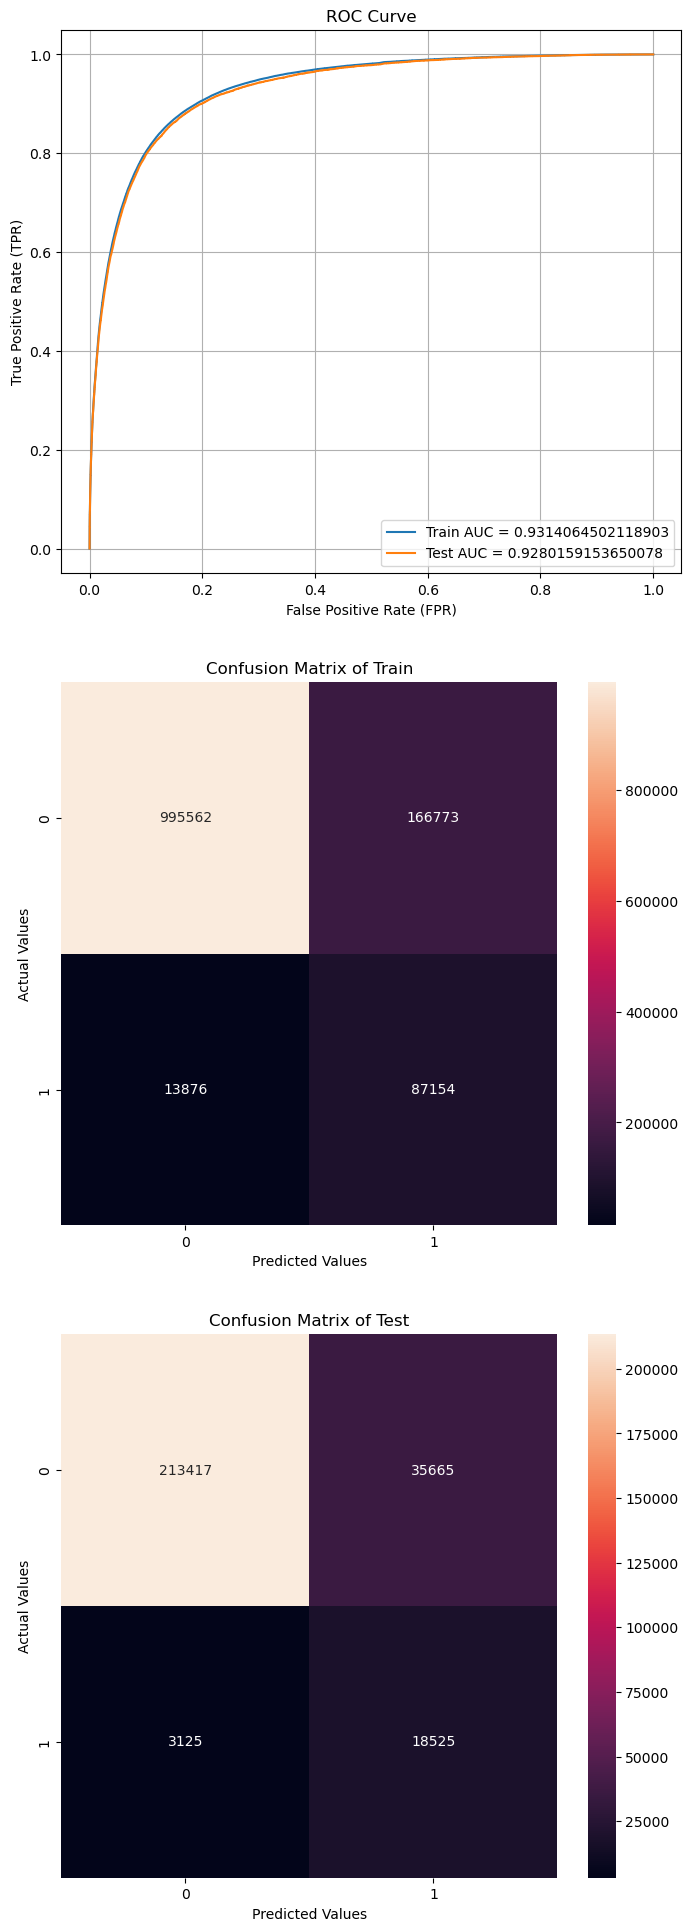

In [ ]:
opt_svm_tfidf = svm_tfidf.optimised_model_instance(train, test, X_train_tfidf, y_train, X_test_tfidf, y_test, roc_and_confusion=True)

### **3.3.3 SVM on W2V**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [10:46<00:00, 46.18s/it]


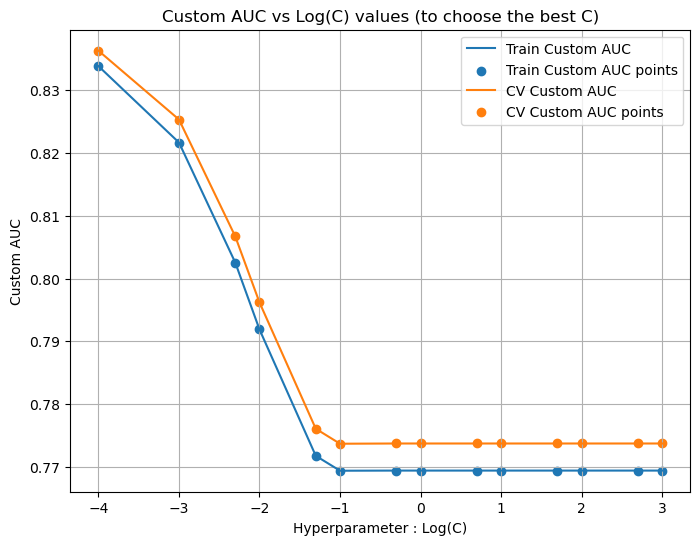

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
0,0.0001,0.833844,0.836303
1,0.0010,0.821670,0.825338
2,0.0050,0.802541,0.806711
3,0.0100,0.791874,0.796183
4,0.0500,0.771737,0.776052
8,5.0000,0.769387,0.773704
9,10.0000,0.769387,0.773704
10,50.0000,0.769387,0.773704
11,100.0000,0.769387,0.773704
12,500.0000,0.769387,0.773704


In [ ]:
MODEL_NAME = 'svm_w2v'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

svm_w2v = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
svm_w2v.model_tuning(train, cv, X_train_w2v, y_train, X_cv_w2v, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8338436669303246
Test Custom AUC Metric: 0.8323440101817989


Train Overall AUC Metric: 0.8654908871382954
Test Overall AUC Metric: 0.8649245700419794
The maximum value of TPR*(1-FPR) 0.6200999595888912 for threshold 0.071


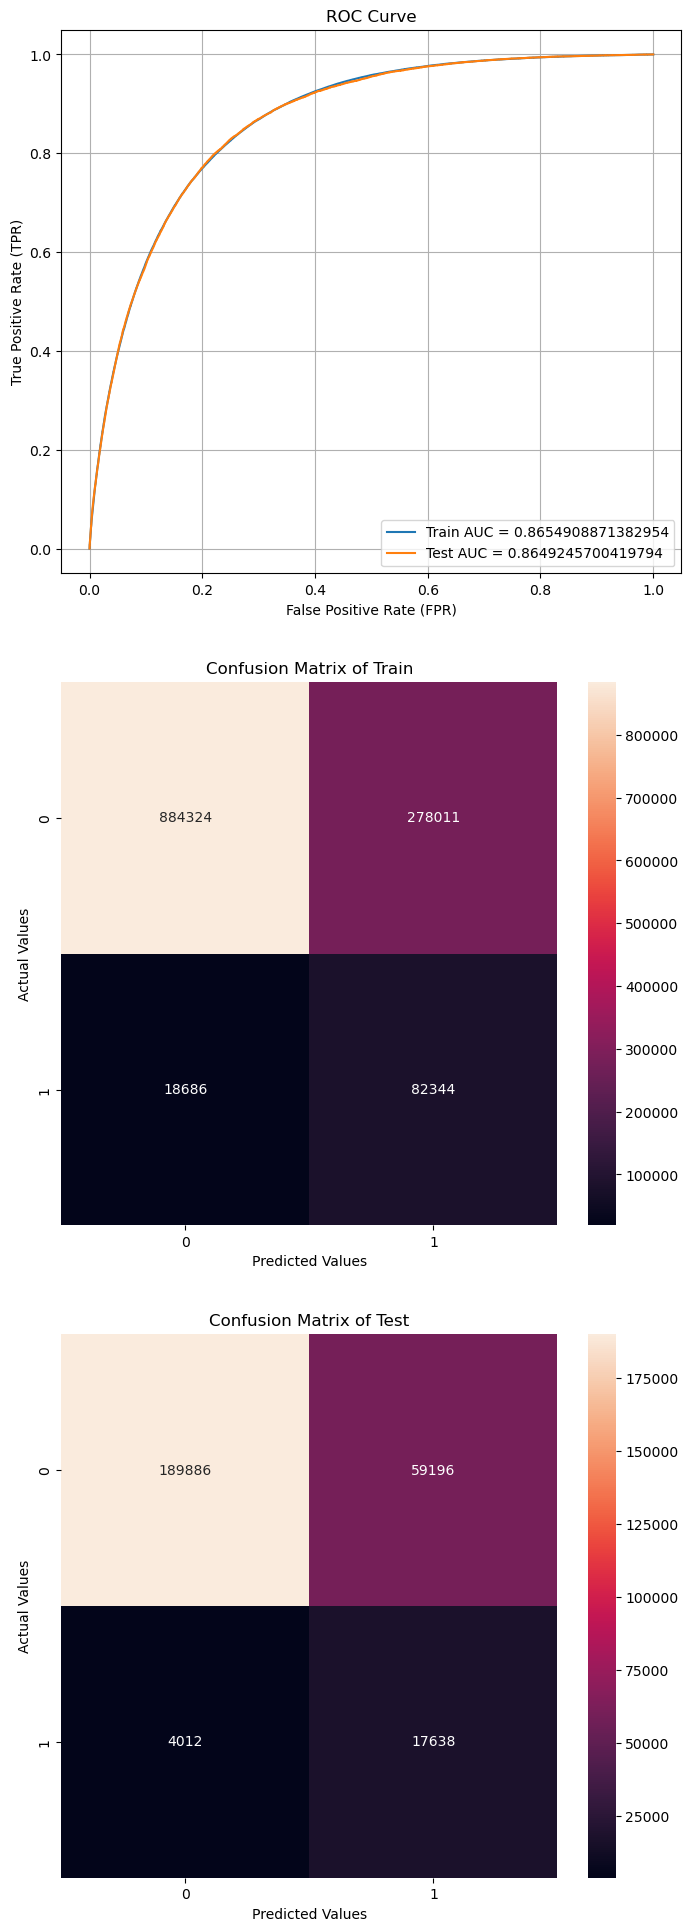

In [ ]:
opt_svm_w2v = svm_w2v.optimised_model_instance(train, test, X_train_w2v, y_train, X_test_w2v, y_test, roc_and_confusion=True)

### **3.3.4 SVM on Glove**

100%|██████████████████████████████████████████████████████████████████████████| 14/14 [09:51<00:00, 42.22s/it]


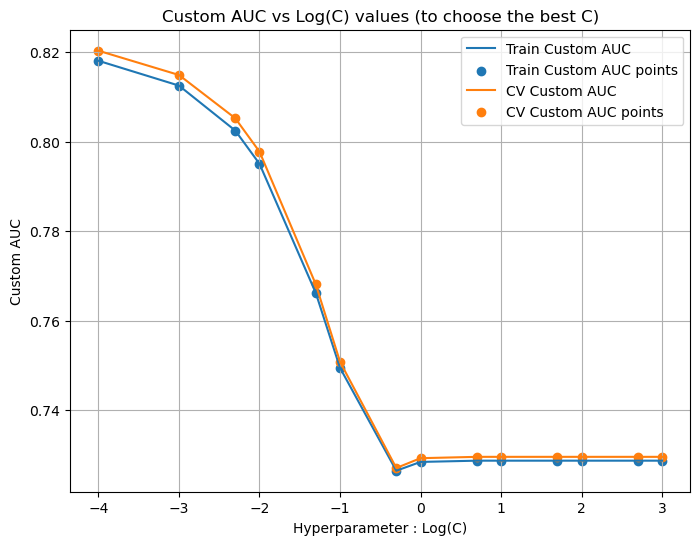

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
0,0.0001,0.818110,0.820363
1,0.0010,0.812561,0.814934
2,0.0050,0.802506,0.805261
3,0.0100,0.795073,0.797790
4,0.0500,0.766187,0.768120
5,0.1000,0.749443,0.750803
9,10.0000,0.728683,0.729540
10,50.0000,0.728683,0.729540
11,100.0000,0.728683,0.729540
12,500.0000,0.728683,0.729540


In [ ]:
MODEL_NAME = 'svm_glove'
PARAM_RANGE = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

svm_glove = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
svm_glove.model_tuning(train, cv, X_train_glove, y_train, X_cv_glove, y_cv, plot_results=True)

Train Custom AUC Metric: 0.818109661728435
Test Custom AUC Metric: 0.8158380917191441


Train Overall AUC Metric: 0.8549378060257163
Test Overall AUC Metric: 0.8547062078464825
The maximum value of TPR*(1-FPR) 0.603527773743874 for threshold 0.071


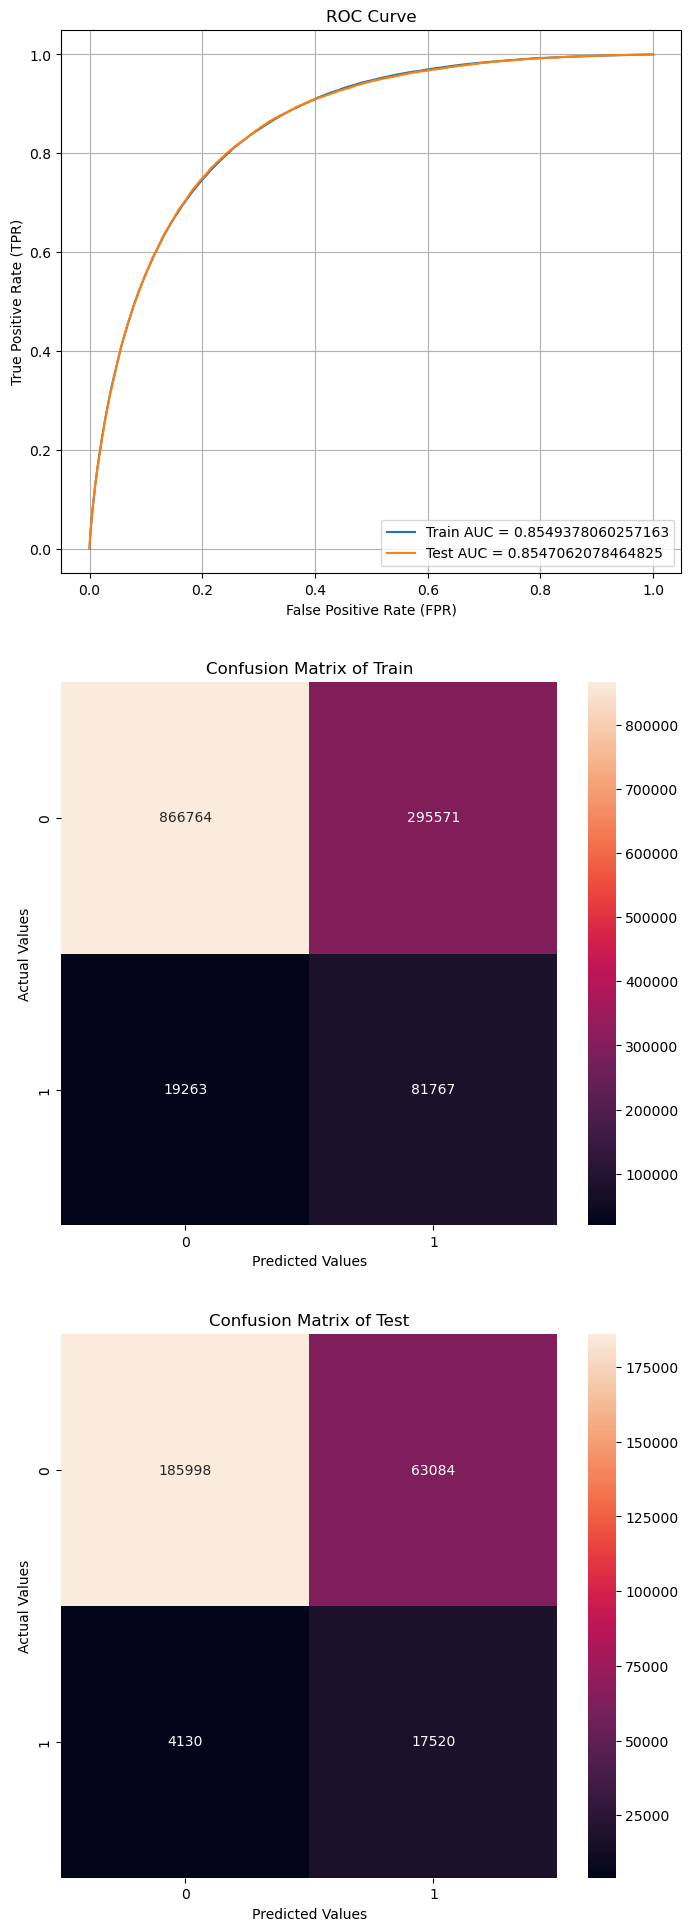

In [ ]:
opt_svm_glove = svm_glove.optimised_model_instance(train, test, X_train_glove, y_train, X_test_glove, y_test, roc_and_confusion=True)

## **3.4 Random Forest**

### **3.4.1 Random Forest on BOW**

100%|████████████████████████████████████████████████████████████████████████████| 7/7 [04:18<00:00, 36.94s/it]


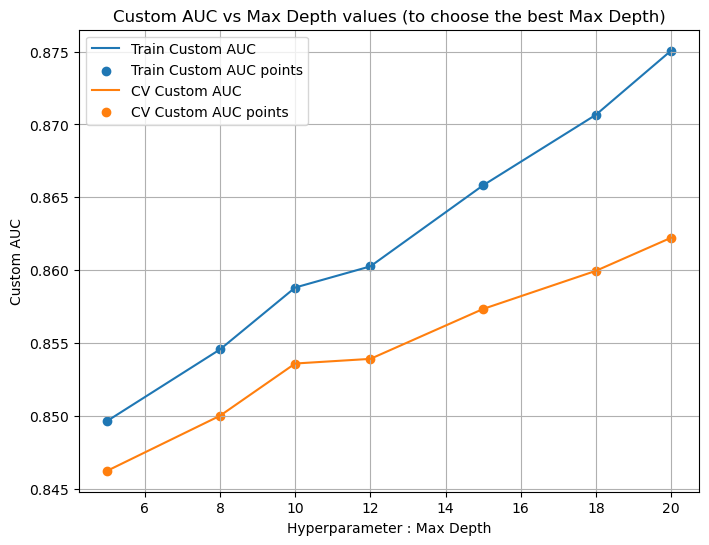

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
6,20,0.875057,0.862226
5,18,0.870658,0.859959
4,15,0.865825,0.857345
3,12,0.860267,0.853922
2,10,0.858816,0.853605
1,8,0.854573,0.850024
0,5,0.849671,0.846252


In [ ]:
MODEL_NAME = 'rf_bow'
PARAM_RANGE = [5, 8, 10, 12, 15, 18, 20]

rf_bow = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
rf_bow.model_tuning(train, cv, X_train_bow, y_train, X_cv_bow, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8750568697948944
Test Custom AUC Metric: 0.8617196999638783


Train Overall AUC Metric: 0.9077126410006171
Test Overall AUC Metric: 0.9009680872876519
The maximum value of TPR*(1-FPR) 0.6923175117477505 for threshold 0.055


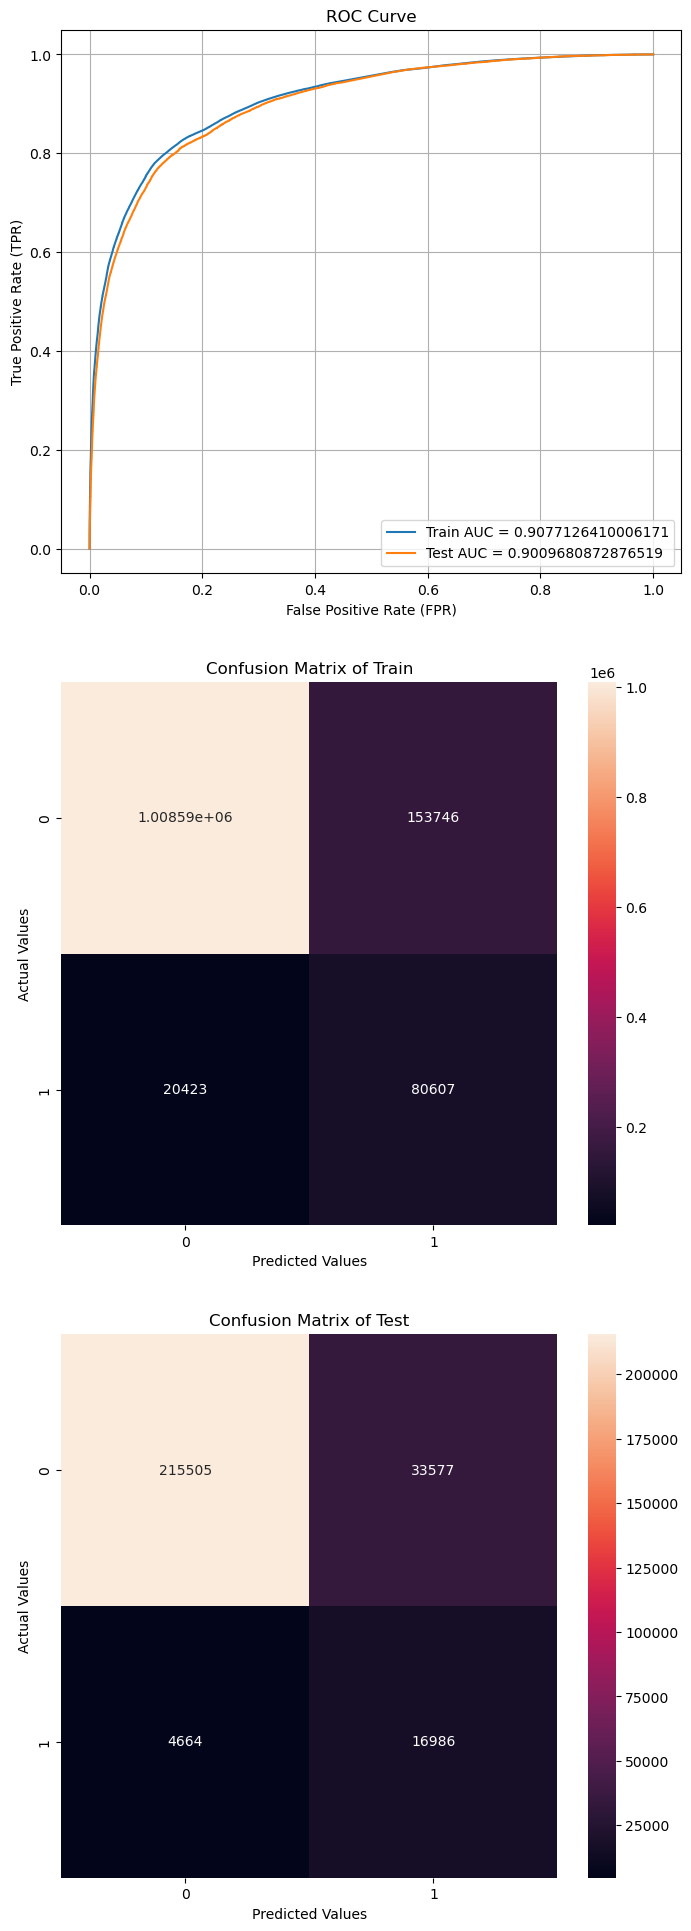

In [ ]:
opt_rf_bow = rf_bow.optimised_model_instance(train, test, X_train_bow, y_train, X_test_bow, y_test, roc_and_confusion=True)

### **3.4.2 Random Forest on TF-IDF**

100%|████████████████████████████████████████████████████████████████████████████| 7/7 [04:36<00:00, 39.52s/it]


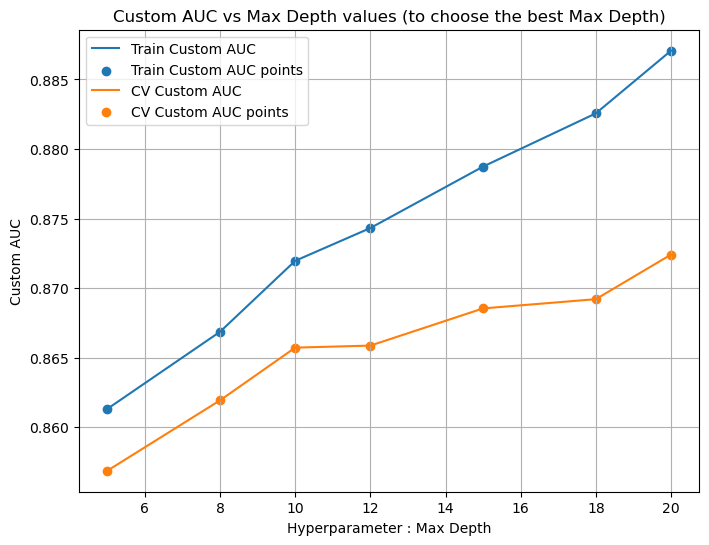

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
6,20,0.887062,0.872413
5,18,0.882561,0.869209
4,15,0.878737,0.868546
3,12,0.874322,0.865873
2,10,0.871966,0.865728
1,8,0.866868,0.861940
0,5,0.861325,0.856882


In [ ]:
MODEL_NAME = 'rf_tfidf'
PARAM_RANGE = [5, 8, 10, 12, 15, 18, 20]

rf_tfidf = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
rf_tfidf.model_tuning(train, cv, X_train_tfidf, y_train, X_cv_tfidf, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8870624395767297
Test Custom AUC Metric: 0.8704794295061472


Train Overall AUC Metric: 0.9138558178017174
Test Overall AUC Metric: 0.9041410236680081
The maximum value of TPR*(1-FPR) 0.710563296911756 for threshold 0.052


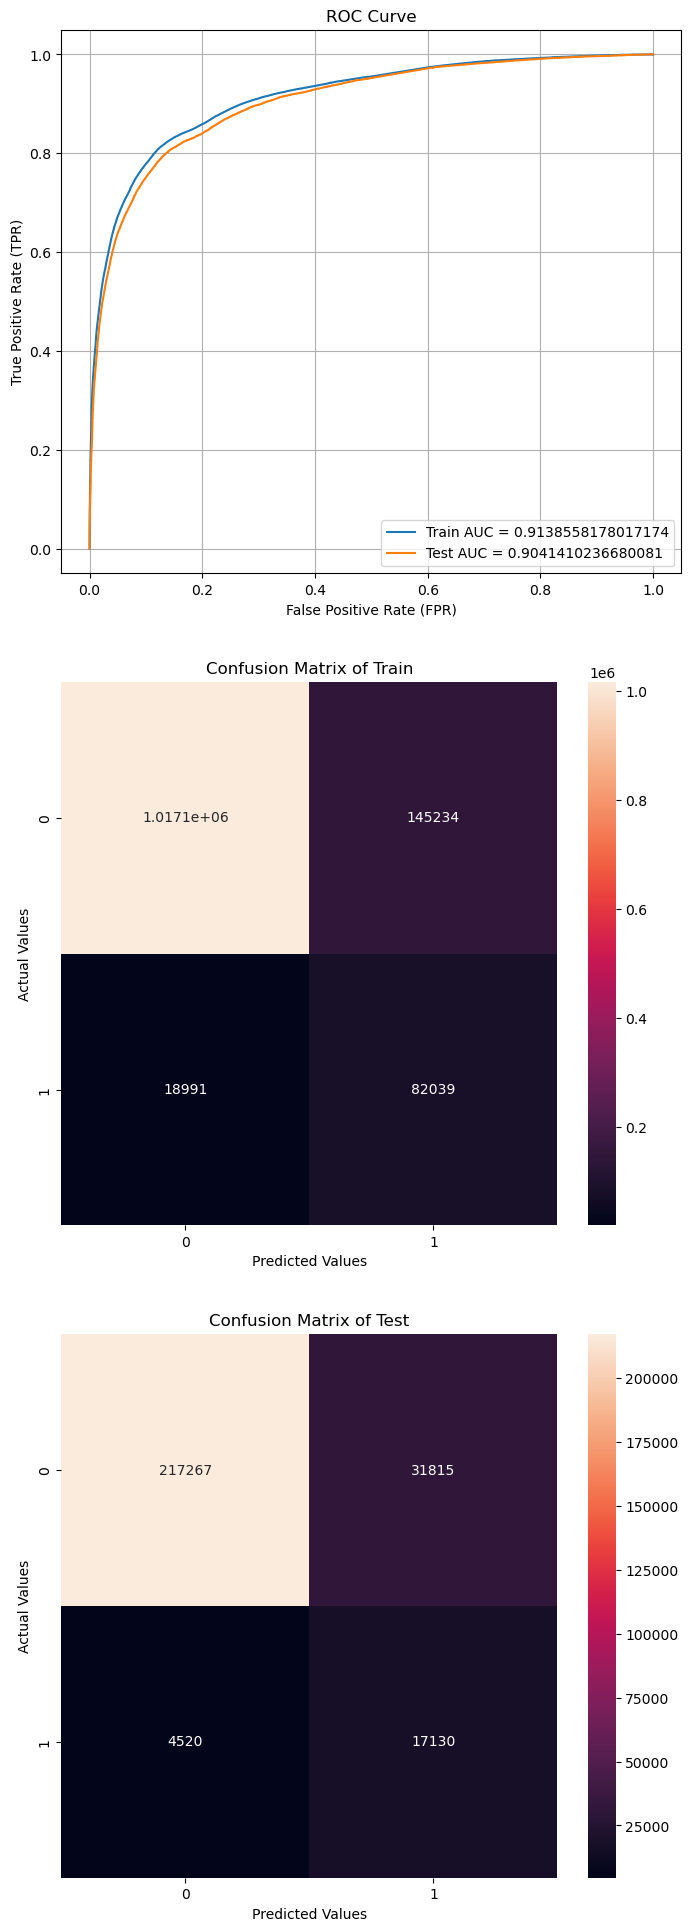

In [ ]:
opt_rf_tfidf = rf_tfidf.optimised_model_instance(train, test, X_train_tfidf, y_train, X_test_tfidf, y_test, roc_and_confusion=True)

### **3.4.3 Random Forest on W2V**

100%|███████████████████████████████████████████████████████████████████████████| 7/7 [55:51<00:00, 478.82s/it]


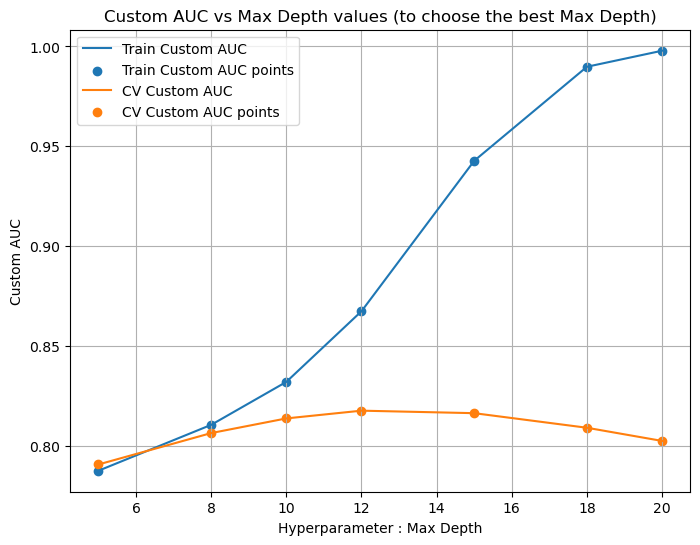

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
3,12,0.867300,0.817481
4,15,0.942685,0.816224
2,10,0.831905,0.813601
5,18,0.989800,0.808918
1,8,0.810380,0.806257
6,20,0.997834,0.802322
0,5,0.787392,0.790532


In [ ]:
MODEL_NAME = 'rf_w2v'
PARAM_RANGE = [5, 8, 10, 12, 15, 18, 20]

rf_w2v = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
rf_w2v.model_tuning(train, cv, X_train_w2v, y_train, X_cv_w2v, y_cv, plot_results=True)

Train Custom AUC Metric: 0.8673004500595285
Test Custom AUC Metric: 0.8125555815839265


Train Overall AUC Metric: 0.8908526483040136
Test Overall AUC Metric: 0.8371046542024716
The maximum value of TPR*(1-FPR) 0.6552151234316378 for threshold 0.075


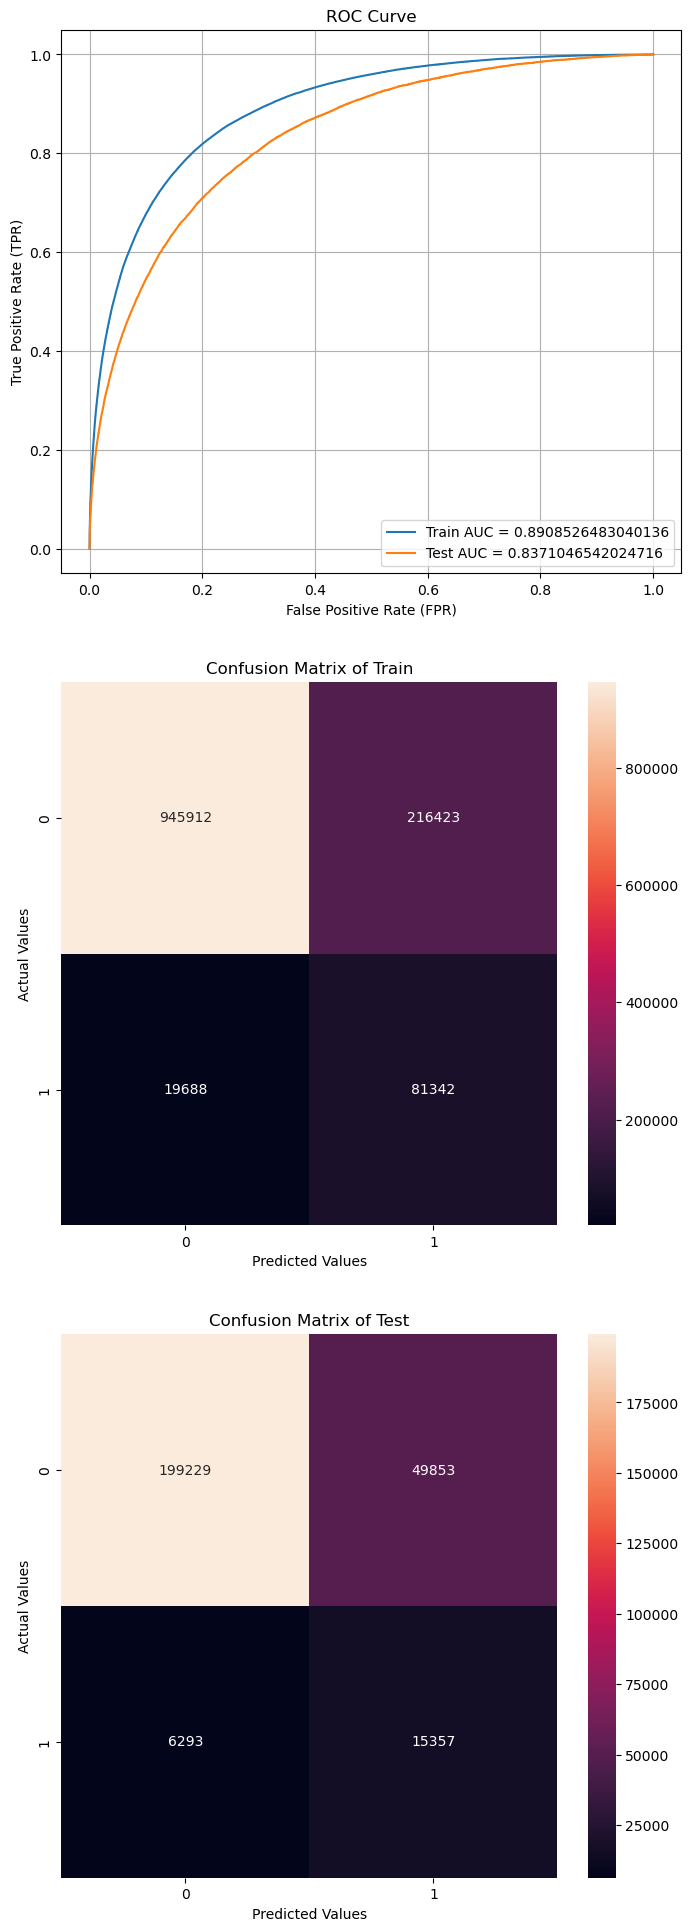

In [ ]:
opt_rf_w2v = rf_w2v.optimised_model_instance(train, test, X_train_w2v, y_train, X_test_w2v, y_test, roc_and_confusion=True)

### **3.4.4 Random Forest on Glove**

100%|███████████████████████████████████████████████████████████████████████████| 7/7 [57:56<00:00, 496.70s/it]


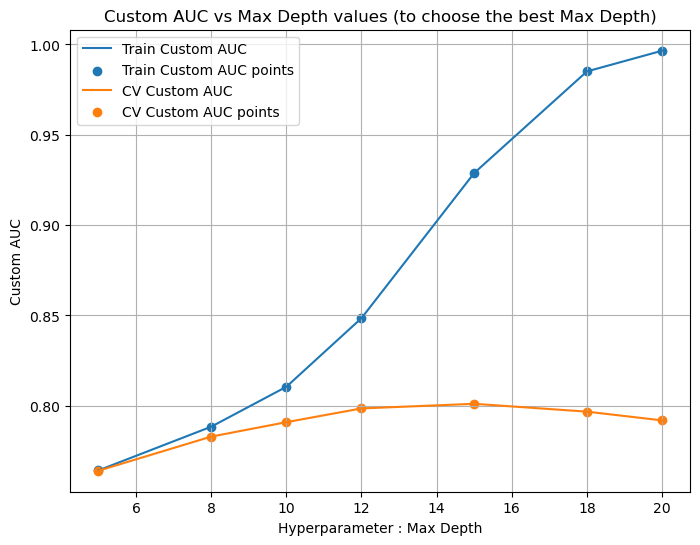

,Hyperparam_Values,Custom_AUC_Train,Custom_AUC_CV
4,15,0.928840,0.801082
3,12,0.848489,0.798521
5,18,0.985077,0.796740
6,20,0.996531,0.791906
2,10,0.810496,0.790924
1,8,0.788405,0.782921
0,5,0.764228,0.764043


In [ ]:
MODEL_NAME = 'rf_glove'
PARAM_RANGE = [5, 8, 10, 12, 15, 18, 20]

rf_glove = BuildModel(TOXICITY_COLUMN, MODEL_NAME, IDENTITY_COLUMNS, PARAM_RANGE)
rf_glove.model_tuning(train, cv, X_train_glove, y_train, X_cv_glove, y_cv, plot_results=True)

Train Custom AUC Metric: 0.9288396877389399
Test Custom AUC Metric: 0.7993626513339173


Train Overall AUC Metric: 0.9471033481502545
Test Overall AUC Metric: 0.8205153016101453
The maximum value of TPR*(1-FPR) 0.7598722468370294 for threshold 0.088


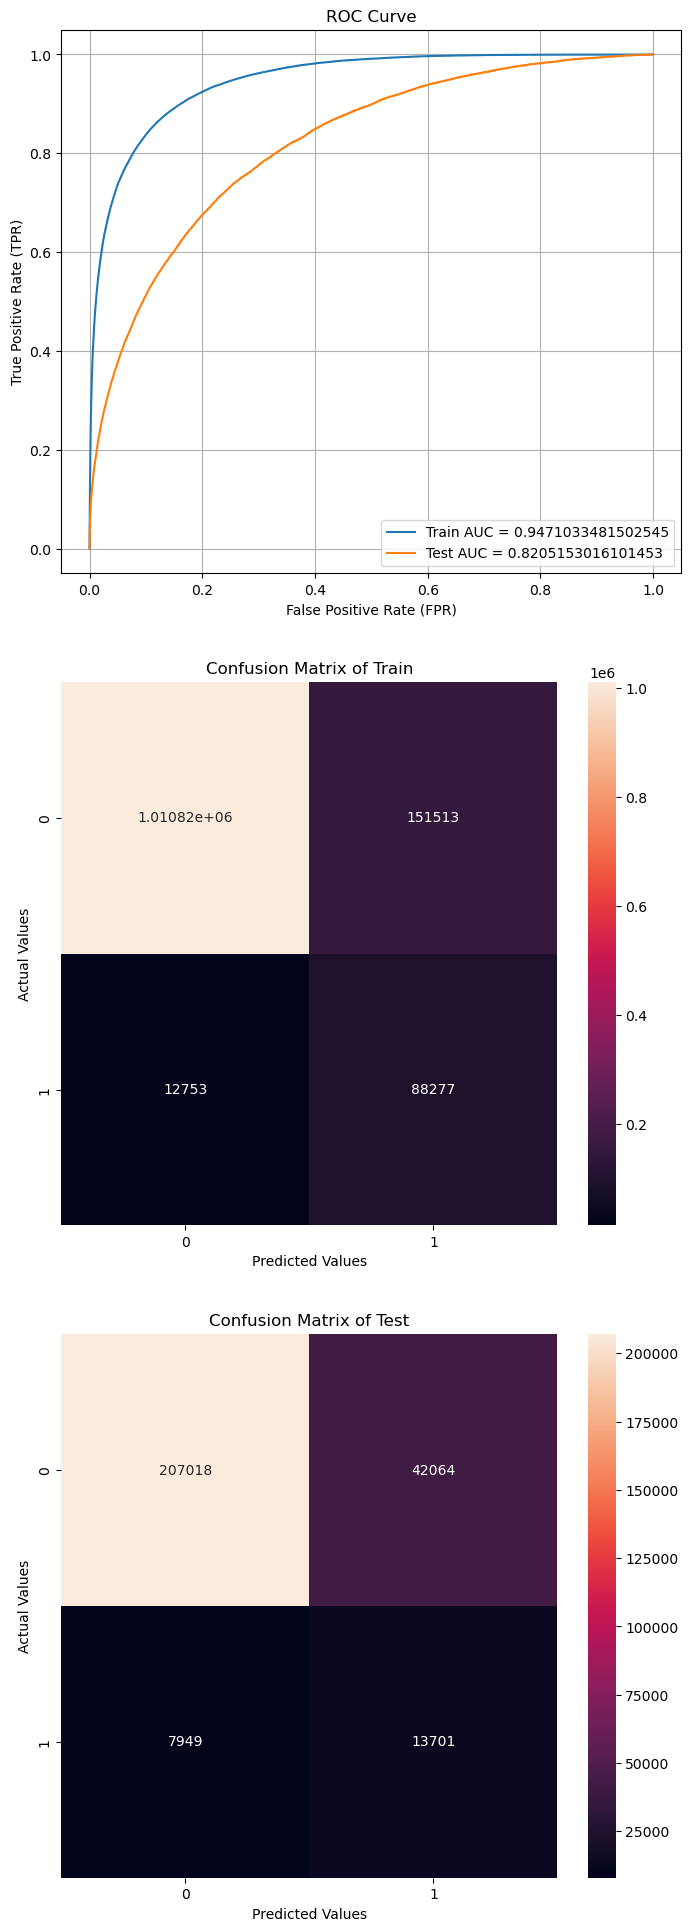

In [ ]:
opt_rf_glove = rf_glove.optimised_model_instance(train, test, X_train_glove, y_train, X_test_glove, y_test, roc_and_confusion=True)

## **4. Summary**

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Vectorization", "Overall AUC", "Custom AUC"]
x.add_rows(
    [
        ["MultinomialNB", "BOW", 0.85, 0.82],
        ["MultinomialNB", "TFIDF", 0.87, 0.85],
        ["LogisticRegression", "BOW", 0.92, 0.89],
        ["LogisticRegression", "TFIDF", 0.93, 0.90],
        ["LogisticRegression", "W2V", 0.86, 0.83],
        ["LogisticRegression", "Glove", 0.85, 0.81],
        ["SVM", "BOW", 0.92, 0.89],
        ["SVM", "TFIDF", 0.92, 0.88],
        ["SVM", "W2V", 0.86, 0.83],
        ["SVM", "Glove", 0.85, 0.81],
        ["RandomForest", "BOW", 0.90, 0.86],
        ["RandomForest", "TFIDF", 0.90, 0.87],
        ["RandomForest", "W2V", 0.83, 0.81],
        ["RandomForest", "Glove", 0.82, 0.79],
        
    ]
)

print(x)

+--------------------+---------------+-------------+------------+
|       Model        | Vectorization | Overall AUC | Custom AUC |
+--------------------+---------------+-------------+------------+
|   MultinomialNB    |      BOW      |     0.85    |    0.82    |
|   MultinomialNB    |     TFIDF     |     0.87    |    0.85    |
| LogisticRegression |      BOW      |     0.92    |    0.89    |
| LogisticRegression |     TFIDF     |     0.93    |    0.9     |
| LogisticRegression |      W2V      |     0.86    |    0.83    |
| LogisticRegression |     Glove     |     0.85    |    0.81    |
|        SVM         |      BOW      |     0.92    |    0.89    |
|        SVM         |     TFIDF     |     0.92    |    0.88    |
|        SVM         |      W2V      |     0.86    |    0.83    |
|        SVM         |     Glove     |     0.85    |    0.81    |
|    RandomForest    |      BOW      |     0.9     |    0.86    |
|    RandomForest    |     TFIDF     |     0.9     |    0.87    |
|    Rando

## **5. References**
- https://www.kaggle.com/code/dborkan/benchmark-kernel#Define-bias-metrics,-then-evaluate-our-new-model-for-bias-using-the-validation-set-predictions (Custom AUC Metric)
- https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 (Simple Text Classification Guide)
- https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b (Naive Bayes Variants Explanation)

While building the model I had very naive question about whether we should perform rescaling on vectorized data when applying linear algorithms because they are distance based, so I searched around the web to find answers: 
- https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features
- https://stackoverflow.com/questions/69850342/logistics-regression-svc-do-we-need-to-do-scaling-if-features-are-bow-tf-idf
- https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/ch04.html (Informative article on effects of feature scaling over vectorized text data)

Model Calibration references:
- https://www.srose.biz/machine-learning/thresholding-and-calibration-for-imbalanced-classification/ 
- https://wttech.blog/blog/2021/a-guide-to-model-calibration/#:~:text=Calibration%20is%20important%2C%20albeit%20often,processing%20of%20the%20model%20outputs.
- https://scikit-learn.org/stable/modules/calibration.html?highlight=calibration
- https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv